In [41]:
import scipy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import io
from scipy import signal
from IPython.display import display
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import sys


## Calcular la media entre los electrodos 8, 44, 80, 131 y 185 (el primer electrodo es el 0) y realizar una figura que muestre las frecuencias en el eje Y, los epochs en el eje X, y la potencia usando una escala de color

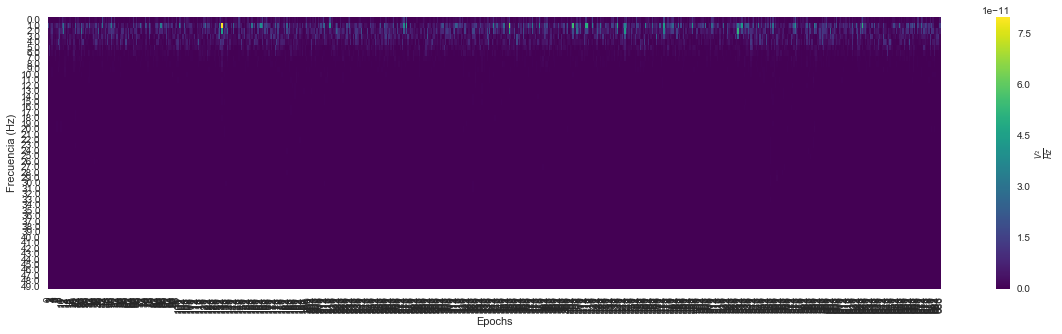

In [18]:
x = (sc.io.loadmat('datasetP/P02.mat'))['data']

epochs = len(x)
# epochs = 1
electrodes = 256
measures = 201

powersDF = None

fig, ax = plt.subplots(figsize=(20,5))

for i in range(epochs):
    epoch = pd.DataFrame(x[i])
    fourier = sc.signal.welch(epoch.loc[[7, 43, 79, 130, 184]].mean(), nperseg=measures, fs = 201)
    if powersDF is None:
        powersDF = pd.DataFrame(index = np.round(fourier[0], 2))
    powersDF[i] = pd.Series(fourier[1], index = powersDF.index)

sns.heatmap(powersDF[powersDF.index < 50], cmap = 'viridis', cbar_kws = {'label': r'$\frac{V^{2}}{Hz}$'})
plt.xlabel('Epochs')
plt.ylabel('Frecuencia (Hz)')
plt.show()


## Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) y epochs para cada sujeto

In [46]:
deltaRange = [0.0, 4.0]
thetaRange = [4.0, 8.0]
alphaRange = [8.0, 13.0]
betaRange = [13.0, 30.0]
gammaRange = [30.0, 50.0]
classification = ['P'] * 10 + ['S'] * 10
names = list(map((lambda x: ('0'+ str(x))[-2:]), range(1,11)))
# names = ['02']
datasets = ['datasetP/P', 'datasetS/S']
# datasets = ['datasetP/P']

meanDFs = []
subjectsDelta = []
subjectsTheta = []
subjectsAlpha = []
subjectsBeta = []
subjectsGamma = []
bandNames = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

considerateInBins = []

df = pd.DataFrame(columns = bandNames)

for dataset in datasets:
    for name in names:
        x = (sc.io.loadmat(dataset + name + '.mat'))['data']
        epochs = len(x)
        electrodes = 256
        measures = 201

        epochAcum = None
        epochAcumDF = None
        for i in range(epochs):
            dfe = pd.DataFrame(x[i])
            epoch = dfe.sum()
            if epochAcum is None:
                epochAcumDF = dfe
                epochAcum = epoch
            else:
                epochAcumDF = epochAcumDF.add(dfe)
                epochAcum = epochAcum.add(epoch)
            if np.random.random_sample() * 100 < 5:
                considerateInBins.append(dfe)
        
        epochAcum = epochAcum.divide(epochs * electrodes)
        epochAcumDF = epochAcumDF.divide(epochs)
        meanDFs.append(epochAcumDF)
        fourier = sc.signal.welch(epochAcum, nperseg=measures, fs = 201)
        frecs = fourier[0]
        powers = fourier[1]
        theta = next(i for i, v in enumerate(frecs) if v >= thetaRange[0] and v < thetaRange[1])
        alpha = next(i for i, v in enumerate(frecs) if v >= alphaRange[0] and v < alphaRange[1])
        beta = next(i for i, v in enumerate(frecs) if v >= betaRange[0] and v < betaRange[1])
        gamma = next(i for i, v in enumerate(frecs) if v >= gammaRange[0] and v < gammaRange[1])
        subjectsDelta.append(powers[:theta].mean())
        subjectsTheta.append(powers[theta:alpha].mean())
        subjectsAlpha.append(powers[alpha:beta].mean())
        subjectsBeta.append(powers[beta:gamma].mean())
        subjectsGamma.append(powers[gamma:].mean())
        index = len(subjectsDelta)
        df = df.append((pd.Series({bandNames[0]: subjectsDelta[-1], bandNames[1]: subjectsTheta[-1], bandNames[2]: subjectsAlpha[-1], bandNames[3]: subjectsBeta[-1], bandNames[4]: subjectsGamma[-1]})).rename('Subject ' + names[(index - 1) % 10] + ' ' + classification[index - 1]))
display(df)


,Delta,Theta,Alpha,Beta,Gamma
Subject 01 P,1.933618e-17,8.238647e-17,4.174321e-18,1.170747e-18,5.460780e-20
Subject 02 P,4.933276e-17,1.592153e-17,1.255062e-18,3.657378e-19,3.174904e-20
Subject 03 P,8.579026e-17,8.927993e-18,2.530623e-18,7.835320e-19,3.328533e-20
Subject 04 P,6.627825e-18,3.045901e-18,1.437712e-19,1.659174e-20,3.063610e-22
Subject 05 P,6.515051e-17,3.555999e-16,3.639976e-17,1.450163e-17,3.942575e-19
Subject 06 P,2.325545e-18,5.050404e-19,7.865331e-20,8.049402e-21,8.603865e-22
Subject 07 P,5.181191e-17,8.452204e-17,1.780590e-17,8.251151e-19,3.350370e-20
Subject 08 P,3.158920e-16,1.117502e-16,4.583215e-18,3.090276e-19,1.061924e-20
Subject 09 P,8.936738e-15,2.633642e-15,2.294612e-16,9.710163e-16,3.550572e-17
Subject 10 P,3.390567e-18,1.906765e-19,4.650550e-20,9.425921e-21,4.121588e-22


## Tomar la potencia de cada sujeto en la banda Alpha y graficar cada uno de los graficos categóricos de seaborn

20


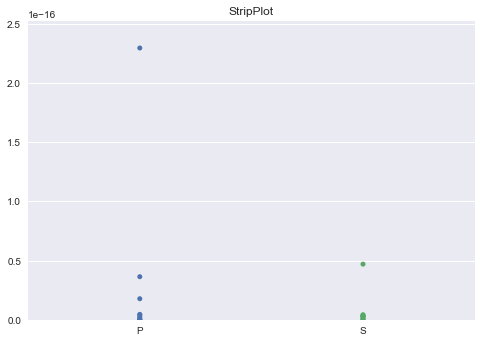

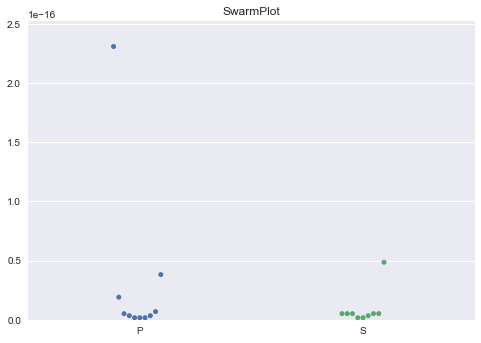

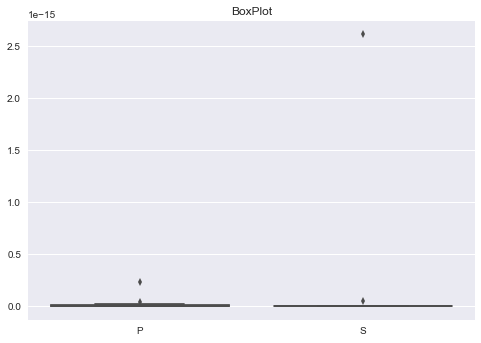

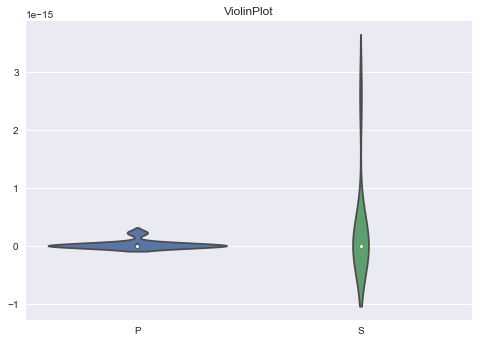

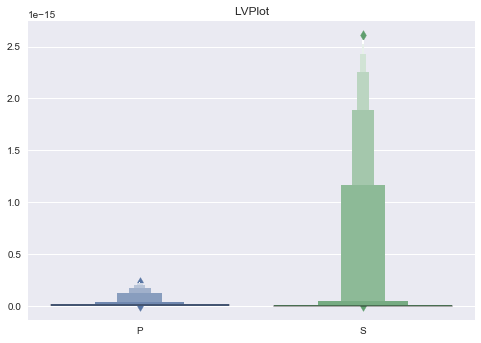

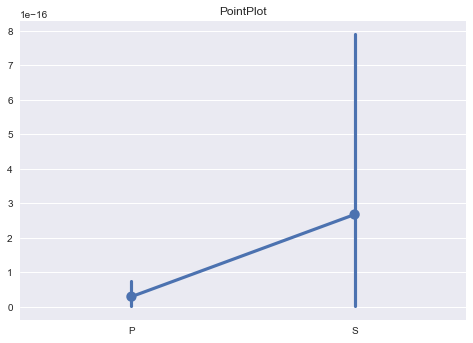

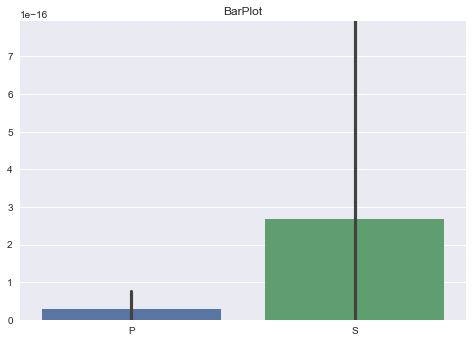

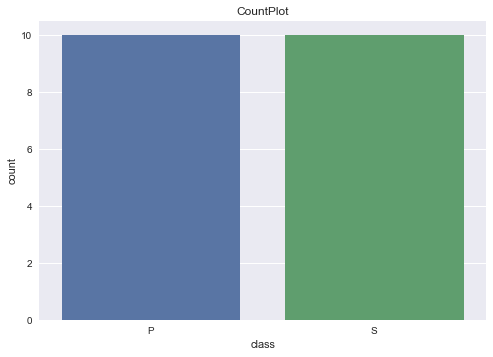

In [12]:
df = pd.DataFrame({'P': subjectsAlpha[:10], 'S': subjectsAlpha[10:]})
plotNames = ['StripPlot', 'SwarmPlot', 'BoxPlot', 'ViolinPlot', 'LVPlot', 'PointPlot', 'BarPlot', 'CountPlot']
plots = [sns.stripplot, sns.swarmplot, sns.boxplot, sns.violinplot, sns.lvplot, sns.pointplot, sns.barplot]

for i, plotClass in enumerate(plots):
    fig = plotClass(data = df)
    if (i < 2):
        fig.set_ylim([0, df['P'].max() * 1.1])
    plt.title(plotNames[i])
    plt.show()

df_new = pd.DataFrame({'class': ['P'] * 10 + ['S'] * 10, 'values': subjectsAlpha})
sns.countplot(x = 'class', data = df_new)
plt.title(plotNames[-1])
plt.show()


## ¿Cuál recomendaría para graficar y comparar distribuciones?
Para comparar las distribuciones recomendamos utilizar violin plot. En este gráfico se visualiza la distribución de los datos y su probabilidad de densidad, ya que es una combinación entre un density plot y un box plot. En el primer tipo de gráfico vemos la distrubición de los datos, mientras que el segundo nos da información sobre la media y outliers (entre otros).

En un violin plot, las secciones más anchas representan mayor probabilidad de que los datos se ubiquen en dicha región; las secciones más angostas señalan una menor probablidad de que esto suceda.

Podemos observar que la banda de frecuencia alfa para la categoría de pacientes P presenta datos anómalos de mayor valor que los pacientes S, mientras que en estos últimos la probabilidad de que la potencia de los electrodos esté en la región determinada por la media es más alta que en la categoría P (aquí las potencias están más distribuidas). Podemos suponer que la media (representada por el punto blanco) de ambas categorías para la banda alfa es similar, mientras que la varianza es distinta (pues las regiones tienen diferentes proporciones).


## Para cada banda de frecuencia, graficarla y realizar un test estadístico apropiado

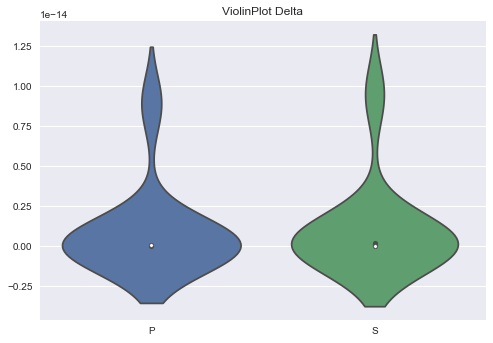

ks_2sample
0.2 0.974789246541
welch
-0.107767112693 0.915376395051
one way
0.0116137505781 0.915372581033


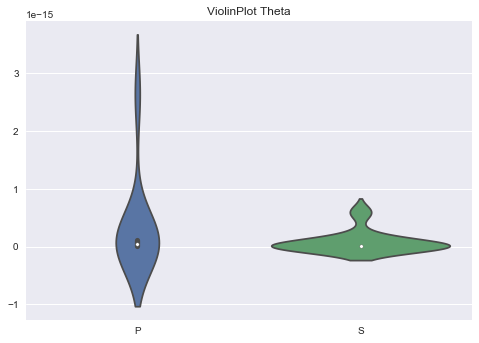

ks_2sample
0.4 0.312852676017
welch
0.932638589584 0.373094031759
one way
0.86981473878 0.363348868548


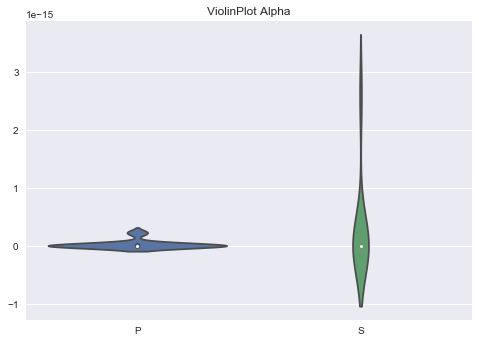

ks_2sample
0.3 0.675078153717
welch
-0.910580217317 0.385915717943
one way
0.829156332168 0.374549807515


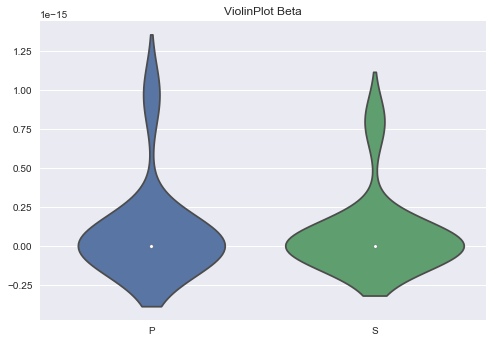

ks_2sample
0.3 0.675078153717
welch
0.137015392563 0.892595528125
one way
0.0187732177992 0.892539553068


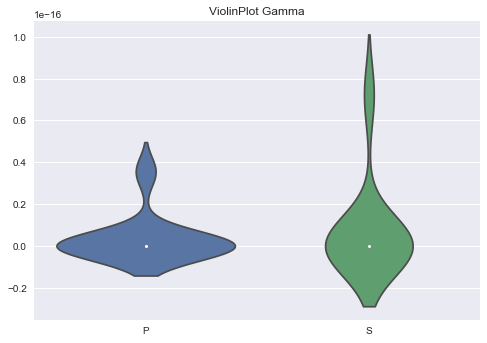

ks_2sample
0.3 0.675078153717
welch
-0.455586109299 0.65615222914
one way
0.207558702986 0.654135620997
                       sum_sq    df         F    PR(>F)
C(Band)          1.370848e-29   4.0  1.878292  0.121087
C(Type)          1.364962e-32   1.0  0.007481  0.931267
C(Band):C(Type)  6.739392e-31   4.0  0.092341  0.984652
Residual         1.642134e-28  90.0       NaN       NaN


In [19]:
formula = 'Value ~ C(Band) + C(Type) + C(Band):C(Type)'
subjectsBands = [subjectsDelta, subjectsTheta, subjectsAlpha, subjectsBeta, subjectsGamma]
dfGeneral = pd.DataFrame()
for i, subjectsBand in enumerate(subjectsBands):
    df = pd.DataFrame({'P': subjectsBand[:10], 'S': subjectsBand[10:]})
    dfCustomP = pd.DataFrame({'Value': subjectsBand[:10], 'Type': 'P', 'Band': bandNames[i]})
    dfCustomS = pd.DataFrame({'Value': subjectsBand[10:], 'Type': 'S', 'Band': bandNames[i]})
    dfGeneral = dfGeneral.append(dfCustomP)
    dfGeneral = dfGeneral.append(dfCustomS)
    sns.violinplot(data = df)
    plt.title('ViolinPlot ' + bandNames[i])
    plt.show()
    t, p = sc.stats.ks_2samp(df['P'], df['S'])
    print ('ks_2sample')
    print t, p
    t, p = sc.stats.ttest_ind(df['P'], df['S'], equal_var = False)
    print 'welch'
    print t, p
    s, p = sc.stats.f_oneway(df['P'], df['S'])
    print 'one way'
    print s, p

model = ols(formula, dfGeneral).fit()
aov_table = statsmodels.stats.anova.anova_lm(model, typ=2)
print(aov_table)


## Repetir para los valores normalizados
Este punto queda incluído en el experimento anterior, pues consideramos el promedio de los valores para cada ancho de banda.

## Computar una medida de información intra-electrodo. Calcular la media entre canales y epochs para cada sujeto. Realizar el gráfico elegido en la sección anterior, acompañado del test estadístico apropiado

In [82]:
def scottRule(powers):
    ampMax = max(powers)
    ampMin = min(powers)
    interval = ampMax-ampMin
    n = math.ceil(float(interval) / (3.5 * np.std(powers) * (len(powers) ** (-1 / 3.0))))
    return n, float(interval) / n

nMean = None
nAcum = []
maxAcum = []
minAcum = []
for epoch in considerateInBins:
    fourier = sc.signal.welch(meanEpoch, nperseg=measures, fs = 201)
    for f in fourier[1]:
        n, _ = scottRule(powers)
        nAcum.append(n)
        maxAcum.append(max(f))
        minAcum.append(min(f))
nMean = np.mean(nAcum)
maxPower = np.mean(maxAcum)
minPower = np.mean(minAcum)


In [98]:
# maxPower = None
# minPower = sys.maxint

ffts = []
for meanEpoch in meanDFs:
    fourier = sc.signal.welch(meanEpoch, nperseg=measures, fs = 201)
#     for f in fourier[1]:
#         maxPower = max(maxPower, max(f))
#         minPower = min(minPower, min(f))
    ffts.append(fourier[1])
# print maxPower, minPower

interval = maxPower - minPower
step = interval / nMean

def bineador(power):
    val = int(power / step)
    if val > nMean - 1:
        return int(nMean - 1)
    return val

totalSeries = []
for subjectPowers in ffts:
    for powers in subjectPowers:
        series = list(map(bineador, powers))
        totalSeries.append(list(map(bineador, powers)))

for series in totalSeries:
    probabilityOfXs = [(series.count(i)/float(len(series))) for i in list(range(13))]
    entropy = sc.stats.entropy(probabilityOfXs)
    print(entropy)

0.221586210754
0.194134837266
0.299138917158
0.386707551164
0.37298186442
0.37298186442
0.359256177677
0.276730156634
0.26300446989
0.331770965336
0.304319591848
0.26300446989
0.37298186442
0.37298186442
0.318045278592
0.331770965336
0.276730156634
0.304319591848
0.299138917158
0.331770965336
0.318045278592
0.331770965336
0.318045278592
0.276730156634
0.26300446989
0.26300446989
0.318045278592
0.318045278592
0.318045278592
0.276730156634
0.26300446989
0.26300446989
0.166340191002
0.26300446989
0.244098108456
0.26300446989
0.110993138987
0.152614504259
0.166340191002
0.276730156634
0.359256177677
0.318045278592
0.318045278592
0.331770965336
0.299138917158
0.0972674522428
0.0972674522428
0.194134837266
0.26300446989
0.318045278592
0.331770965336
0.318045278592
0.318045278592
0.0555460752689
0.166340191002
0.299138917158
0.26300446989
0.331770965336
0.37298186442
0.304319591848
0.188954162576
0.244098108456
0.304319591848
0.276730156634
0.359256177677
0.244098108456
0.152614504259
0.27686

0.26300446989
0.26300446989
0.244098108456
0.20786052401
0.304319591848
0.304319591848
0.285413230414
0.244098108456
0.244098108456
0.26300446989
0.26300446989
0.26300446989
0.20786052401
0.26300446989
0.249278783147
0.249278783147
0.26300446989
0.304319591848
0.304319591848
0.244098108456
0.244098108456
0.249278783147
0.249278783147
0.276730156634
0.188954162576
0.26300446989
0.230372421712
0.304319591848
0.304319591848
0.318045278592
0.249278783147
0.26300446989
0.26300446989
0.26300446989
0.20786052401
0.276730156634
0.249278783147
0.318079117445
0.326624129498
0.244098108456
0.221827409659
0.26300446989
0.276730156634
0.318045278592
0.276730156634
0.304319591848
0.221827409659
0.221827409659
0.244098108456
0.26300446989
0.318045278592
0.345530490933
0.340349816242
0.318045278592
0.299138917158
0.221827409659
0.263142531617
0.37298186442
0.331770965336
0.331770965336
0.331770965336
0.26300446989
0.340349816242
0.395181070402
0.400361745093
0.395181070402
0.318045278592
0.22158621075

0.110993138987
0.110993138987
0.0555460752689
0.0972674522428
0.188954162576
0.152614504259
0.0555460752689
0.0555460752689
0.0
0.0
0.0555460752689
0.0972674522428
0.244098108456
0.0555460752689
0.0
0.0
0.0
0.188954162576
0.299172756011
0.188954162576
0.318079117445
0.304319591848
0.221827409659
0.221827409659
0.152614504259
0.0555460752689
0.0972674522428
0.0555460752689
0.0555460752689
0.0972674522428
0.359256177677
0.345530490933
0.321443454808
0.318079117445
0.321443454808
0.318079117445
0.221827409659
0.188954162576
0.0555460752689
0.0555460752689
0.0555460752689
0.340349816242
0.340349816242
0.299172756011
0.326624129498
0.326624129498
0.321443454808
0.221827409659
0.252095821156
0.0555460752689
0.321443454808
0.345530490933
0.321443454808
0.340349816242
0.321443454808
0.321443454808
0.221827409659
0.252095821156
0.0555460752689
0.321443454808
0.340349816242
0.299172756011
0.321443454808
0.318079117445
0.285413230414
0.221827409659
0.152614504259
0.0555460752689
0.0
0.0
0.1526145

0.42781311858
0.509703703214
0.523429389957
0.504523028523
0.509703703214
0.722771345423
0.623309926573
0.545305705772
0.504523028523
0.74886196859
0.682551381908
0.781512347931
0.802860430892
0.783540128169
0.844037491123
0.736497032167
0.69962073339
0.675533697265
0.577937753951
0.801372907963
0.640265471065
0.564212067207
0.449905860251
0.504523028523
0.449905860251
0.468812221685
0.449905860251
0.276868218361
0.26300446989
0.26300446989
0.331804804189
0.361863661144
0.340349816242
0.26300446989
0.20786052401
0.26300446989
0.0555460752689
0.361863661144
0.389137077505
0.395003113276
0.395003113276
0.372910371605
0.340349816242
0.244098108456
0.110993138987
0.443754245777
0.479356248336
0.449620281548
0.481857946744
0.376274708967
0.304319591848
0.166340191002
0.490402958797
0.481857946744
0.479356248336
0.427635161454
0.361863661144
0.166340191002
0.479356248336
0.490402958797
0.449620281548
0.402862764249
0.331804804189
0.276868218361
0.441075269495
0.372910371605
0.276868218361
0.

## Repetir para una medida inter-electrodo

In [7]:
# x = (sc.io.loadmat(dataset + name + '.mat'))['data']
x = (sc.io.loadmat('datasetP/' + 'P02' + '.mat'))['data']
epoch0p2 = pd.DataFrame(x[0])

fourierX = sc.signal.welch(epoch0p2.loc[[7]].mean(), nperseg=measures, fs = 201)
powersX = fourierX[1]
ampMaxX = max(powersX)
ampMinX = min(powersX)
intervalX = ampMaxX-ampMinX
nX = math.ceil(intervalX/(3.5*(len(powersX)**(-1/3))*np.std(powersX)))
stepX = intervalX/nX
seriesX = list(map(lambda z: int(z/stepX), powersX))
probabilityOfXs = [(seriesX.count(xi)/float(len(seriesX))) for xi in seriesX]

fourierY = sc.signal.welch(epoch0p2.loc[[8]].mean(), nperseg=measures, fs = 201)
powersY = fourierY[1]
ampMaxY = max(powersY)
ampMinY = min(powersY)
intervalY = ampMaxY-ampMinY
nY = math.ceil(intervalY/(3.5*(len(powersY)**(-1/3))*np.std(powersY)))
stepY = intervalY/nY
seriesY = list(map(lambda z: int(z/stepY), powersY))
probabilityOfYs = [(seriesY.count(yi)/float(len(seriesY))) for yi in seriesY]

# Asumimos P(xi) independiente de P(yj) para todo i,j.
# Luego, P(x,y) = P(x)*P(y)
# entropy = sc.stats.entropy(probabilityOfXs) * sc.stats.entropy(probabilityOfYs)
entropy = 0
for pxi in probabilityOfXs:
    for pyj in probabilityOfYs:
        entropy += pxi*pyj*math.log(pxi*pyj)
entropy = -entropy
print(entropy)

2264.75590163
